In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [2]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


In [3]:
conf = SparkConf().set("spark.ui.port", "4050")

# creamos el contexto y la sesión
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/11 16:14:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/11 16:14:50 WARN Utils: Service 'SparkUI' could not bind on port 4050. Attempting port 4051.


In [50]:
data_covid = sc.textFile('./data/covid_articles_raw.csv')

In [5]:
type(data_covid)

pyspark.rdd.RDD

In [51]:
data_covid.take(10)

['title,content,category',
 'Looking into the truth about modern workplace environments,"Hi, what are you looking for?',
 'By',
 'Published',
 'Workplaces are being transformed, according to the Olivet Nazarene University study ( “ The Truth about Modern Offices “). The days of men and women fitted in formal clothing and working under the harsh glare fluorescent lighting are slipping away. The trends of today are reflective of casual dress codes and soft furnishings.',
 'There are signs too that the ‘ animal penning’ ( read cubicles) are starting to be withdrawn, and replaced with open floor plans ( indications are that over half of workplaces – 51 percent – have gravitated towards the ‘ open office’ or open floor plan concept).',
 'The survey also showed that 77 percent of U.S. located workers are reportedly happy with the way their office is set up. However, as an indication of thoughts about open-plan areas, those with private offices stated they were happiest',
 'Through changing t

### Creamos una función que "limpia" cada línea: se remueven signos de puntuación y otros caracteres. Adicionalmente convertimos el texto a minúscula

In [9]:
def clean_text(line:str) -> str:
    punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~-“”'
    words = ['covid 19','covid19', 'covid19 ', ' covid19', 'said','2020','2021','coronavirus','pandemic']
    lowercased = line.lower()
    for word in words:
        lowercased = lowercased.replace(word, '')
    return lowercased.translate(str.maketrans('','',punct)).strip()

In [10]:
data_covid = data_covid.map(clean_text)

In [11]:
data_covid.take(10)

['titlecontentcategory',
 'looking into the truth about modern workplace environmentshi what are you looking for',
 'by',
 'published',
 'workplaces are being transformed according to the olivet nazarene university study   the truth about modern offices  the days of men and women fitted in formal clothing and working under the harsh glare fluorescent lighting are slipping away the trends of today are reflective of casual dress codes and soft furnishings',
 'there are signs too that the ‘ animal penning’  read cubicles are starting to be withdrawn and replaced with open floor plans  indications are that over half of workplaces – 51 percent – have gravitated towards the ‘ open office’ or open floor plan concept',
 'the survey also showed that 77 percent of us located workers are reportedly happy with the way their office is set up however as an indication of thoughts about openplan areas those with private offices stated they were happiest',
 'through changing technology more employees a

In [12]:
all_words = data_covid.flatMap(lambda line: line.split())

In [13]:
all_words.take(20)

['titlecontentcategory',
 'looking',
 'into',
 'the',
 'truth',
 'about',
 'modern',
 'workplace',
 'environmentshi',
 'what',
 'are',
 'you',
 'looking',
 'for',
 'by',
 'published',
 'workplaces',
 'are',
 'being',
 'transformed']

In [14]:
data_covid_count = all_words.map(lambda word: (word,1))

In [15]:
all_words.count()

415973939

In [16]:
data_covid_rbk = data_covid_count.reduceByKey(lambda a,b: a+b).sortByKey()

In [17]:
data_covid_rbk.persist()

PythonRDD[18] at RDD at PythonRDD.scala:53

In [18]:
data_covid_rbk.take(10)

[('\x02betacyclodextrinsfunctionalized', 1),
 ('\x07easy', 1),
 ('\x07global', 2),
 ('\x07good', 1),
 ('\x08hortaosório', 1),
 ('0', 36241),
 ('00', 6593),
 ('000', 15865),
 ('0000', 281),
 ('00000', 36)]

### Truco para encontrar las palabras con mas ocurrencias:

In [19]:
import nltk

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Dejamos solo las palabras que no sean stopwords

In [22]:
data_covid_rbk = data_covid_rbk.filter(lambda tupla: tupla[0] not in stopwords)

In [23]:
data_covid_rbk.map(lambda tupla: (tupla[1],tupla[0])).sortByKey(False).take(20)

[(989367, 'us'),
 (961651, 'new'),
 (910157, 'covid19'),
 (856812, 'also'),
 (847827, 'people'),
 (762879, 'market'),
 (701859, 'million'),
 (690674, 'year'),
 (642729, 'one'),
 (618743, 'would'),
 (569640, 'may'),
 (563166, 'health'),
 (561388, 'company'),
 (552042, 'time'),
 (547136, 'first'),
 (514243, 'could'),
 (507843, 'business'),
 (453141, 'like'),
 (445763, 'data'),
 (444302, '—')]

In [29]:
wc

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [25]:
word_dict = {tupla[0]:float(tupla[1]) for tupla in data_covid_rbk.collect()}

In [26]:
wc = WordCloud(width=3000,height=1000).generate_from_frequencies(word_dict)

(-0.5, 2999.5, 999.5, -0.5)

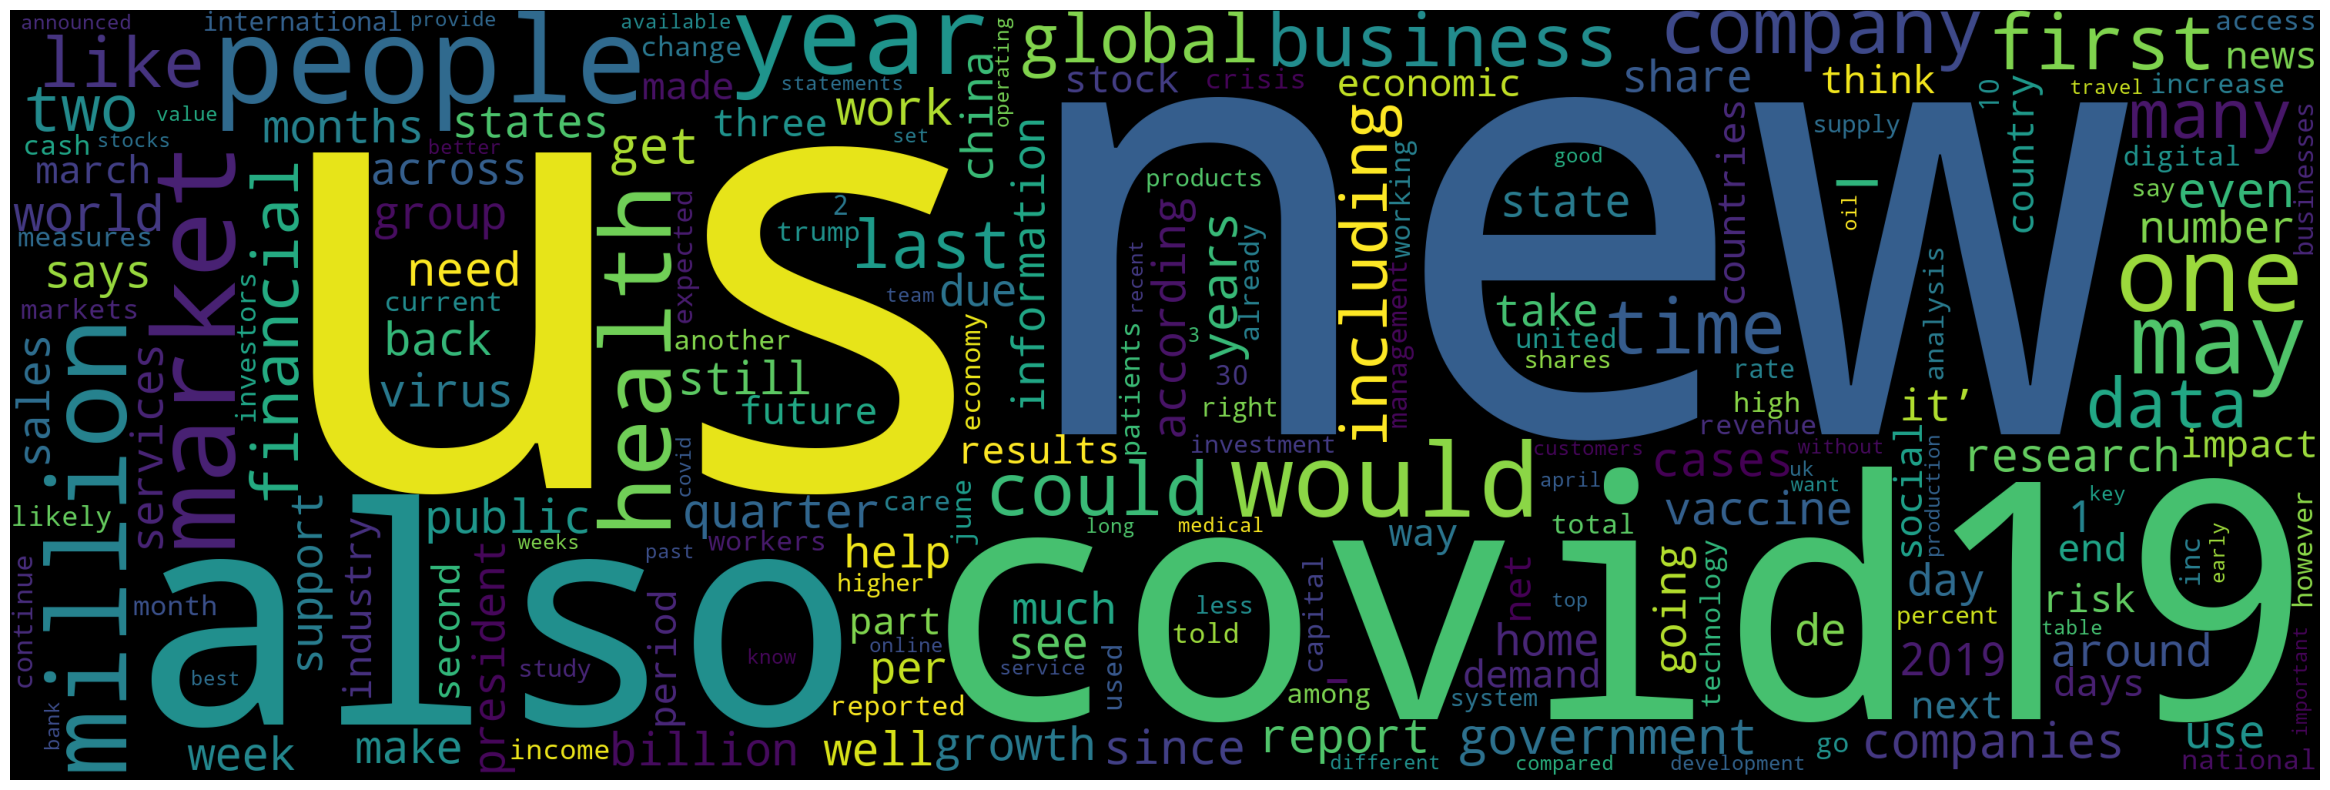

In [27]:
plt.figure(figsize=(30, 10))
plt.imshow(wc)
plt.axis("off")

In [43]:
type(all_words)

pyspark.rdd.PipelinedRDD

In [40]:
dept = [("Finance",10),("Marketing",20),("Sales",30),("IT",40)]
rdd = spark.sparkContext.parallelize(dept)

In [45]:
type(all_words_rdd)

pyspark.rdd.PipelinedRDD

In [48]:
all_words_rdd = all_words.flatMapValues(lambda x : [ (k, x[k]) for k in x.keys()])

In [49]:
all_words_rdd.collect()

22/10/11 17:15:54 ERROR Executor: Exception in task 0.0 in stage 29.0 (TID 730)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 686, in main
    process()
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 678, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 273, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/rdd.py", line 2695, in flat_map_fn
    return ((kv[0], x) for x in f(kv[1]))
  File "/tmp/ipykernel_192/2623929531.py", line 1, in <lambda>
AttributeError: 'str' 

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 29.0 failed 1 times, most recent failure: Lost task 0.0 in stage 29.0 (TID 730) (e9f5fb4e8d75 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 686, in main
    process()
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 678, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 273, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/rdd.py", line 2695, in flat_map_fn
    return ((kv[0], x) for x in f(kv[1]))
  File "/tmp/ipykernel_192/2623929531.py", line 1, in <lambda>
AttributeError: 'str' object has no attribute 'keys'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:559)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:765)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:747)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1021)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2268)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 686, in main
    process()
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 678, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 273, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/rdd.py", line 2695, in flat_map_fn
    return ((kv[0], x) for x in f(kv[1]))
  File "/tmp/ipykernel_192/2623929531.py", line 1, in <lambda>
AttributeError: 'str' object has no attribute 'keys'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:559)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:765)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:747)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1021)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2268)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [47]:
all_words_rdd.map(lambda x : (x[0]))\
    .toDF(("CId"))\
    .show()


ParseException: 
Syntax error at or near end of input(line 1, pos 3)

== SQL ==
CId
---^^^


In [34]:
from pyspark.ml.feature import Word2Vec

In [35]:
w2v = Word2Vec(vectorSize = 100, minCount = 0, maxIter = 100)

In [36]:
w2v.fit(all_words)

AttributeError: 'PipelinedRDD' object has no attribute '_jdf'